Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - kl_loss: 0.0741 - loss: 0.7081 - reconstruction_loss: 0.6341
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 0.0159 - loss: 0.5008 - reconstruction_loss: 0.4849
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0097 - loss: 0.3743 - reconstruction_loss: 0.3646
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0069 - loss: 0.3157 - reconstruction_loss: 0.3088
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0052 - loss: 0.2904 - reconstruction_loss: 0.2852
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0042 - loss: 0.2784 - reconstruction_loss: 0.2742
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0036 - loss: 0.2750 - reconstruction_loss: 0.2714
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0030 - loss: 0.2706 - reconstruction_loss: 0.2676
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0026 - loss: 0.2699 - reconstruc

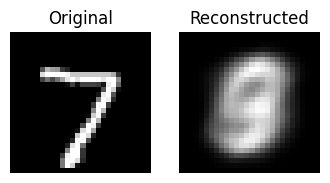

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Use small data for CPU testing
x_train = x_train[:2000]
x_test = x_test[:10]

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

latent_dim = 2

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        return self.z_mean(x), self.z_log_var(x)

# Sampling trick
class Sampler(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(28 * 28, activation='sigmoid')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        return self.reshape(x)

# Full VAE model
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.sampler = Sampler()
        self.decoder = Decoder()

    def call(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(data)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstructed))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

# Create and train
vae = VAE(latent_dim=latent_dim)
vae.compile(optimizer='adam')
vae.fit(x_train, x_train, epochs=20, batch_size=64, verbose=1)

# 🔍 Test on first image
reconstructed, _, _ = vae(x_test)
reconstructed = reconstructed.numpy()

# 🔎 Show original vs reconstructed
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(x_test[0].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(reconstructed[0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()


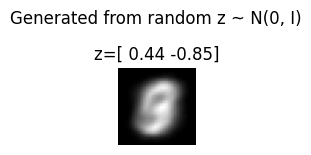

In [11]:
# 🔥 Random sampling from latent space
n = 1  # how many images you want
random_latents = tf.random.normal(shape=(n, latent_dim))
generated_images = vae.decoder(random_latents).numpy()

# 🖼️ Show generated images
plt.figure(figsize=(n, 2))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.title(f"z={random_latents[i].numpy().round(2)}")
    plt.axis('off')
plt.suptitle("Generated from random z ~ N(0, I)")
plt.show()
